## Left Atrial Analysis

In [1]:
from __future__ import division, print_function

%matplotlib inline
from collections import OrderedDict
from warnings import warn, filterwarnings
filterwarnings('ignore', module='matplotlib')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import expit
import peakutils

Read and clean the source spreadsheets for the volumes time series and the recorded average R-R intervals. Build a dictionary of dataframes consisting of indexed time series for LA and LV volumes.  

In [2]:
volumes = 'FullVolumes.xlsx'
rrintervals = 'RRIntervals.xlsx'

df_vols = pd.read_excel(volumes)
df_rrintervals = pd.read_excel(rrintervals).reset_index(drop=True)
df_rrintervals.index = ['RR']

df_vols = df_vols.rename(columns=lambda x: x[:6])
df_rrintervals = df_rrintervals.rename(columns=lambda x: x[:6])

df_la = df_vols.filter(regex='LA-[0-9]{3,3}$')
df_lv = df_vols.filter(regex='LV-[0-9]{3,3}$')
df_times = df_rrintervals.filter(regex='LV-[0-9]{3,3}$').T

# map index in rr times to integers
df_times['PN'] = [int(i[-3:]) for i in df_times.index]
df_times = df_times.set_index('PN')

nrows = df_la.count(axis=0)[0]
df_times['dT'] = df_times['RR'] / nrows
patients = {}
for patno in [int(col[-3:]) for col in df_la]:
    if ('LV-%03d' % patno) not in df_lv:
        warn('No corresponding LV series found for %d - ignoring' % patno)
        continue
    if any(pd.isnull(df_lv['LV-%d' % patno])):
        warn("Wrong number of time points in LV for %s - ignoring." % patno)
        continue
    if any(pd.isnull(df_la['LA-%d' % patno])):
        warn("Wrong number of time points in LA for %s - ignoring." % patno)
        continue
    patients[patno] = pd.concat([
        pd.Series(np.arange(nrows) * df_times['dT'][patno], name='Time'),
        df_lv['LV-%03d' % patno],
        df_la['LA-%03d' % patno],
    ], axis=1).set_index('Time')
    patients[patno].columns = ('LV', 'LA')
    patients[patno].pat_name = 'Patient %d' % patno

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Wrong number of time points in LV for 181 - ignoring.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Wrong number of time points in LA for 247 - ignoring.


Although all the analysis will be on the LA curves, we'll get an estimate of the end systolic time from the LV curve to guide the identification in the less clear cut LA curves. 

In [3]:
def lv_es_time(volumes, times):
    """
    Estimate time of end-systole in LV volume curve.
    Uses filtering and interpolation to get robust and accurate location of minimum.
    """
    SGWINLEN = 5
    SGPOLY = 2
    INTERP = 3    
        
    # smooth curve using savitsky-golay filter
    sg_volumes = savgol_filter(
        x=volumes,
        window_length=SGWINLEN,
        polyorder=SGPOLY,
        mode='interp'
    )
    spline_vols = InterpolatedUnivariateSpline(times, sg_volumes)
    interp_times  = np.linspace(0, times[-1], len(times)*INTERP)
    interp_volumes = spline_vols(interp_times)
    es_index = np.argmin(interp_volumes)
    return interp_times[es_index]

In [4]:
class LAAnalysis:
    """
    Extraction of parameters from LA volume curves.
    Uses a supplied estimate for the ES time (eg from the LV curve)
    to mitigate issues with indistict or multiple maxima.
    """
    SGWINLEN = 5
    SGPOLY = 2
    INTERP = 3
    ESLOWER = 20 # ms
    ESUPPER = 250 # ms
    
    def __init__(self, volumes, times, name, estimated_es_time):
        # smooth curve and generate derivative curve using savitsky-golay filter
        sg_volumes = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN,
            polyorder=self.SGPOLY,
            mode='interp'
        )
        dt_msecs = np.mean(np.diff(times))
        
        # we'll fudge the boundary behaviour to make the identification of the 
        # late filling a bit more robust.        
        sg_derivatives = 0.75 * savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+2,
            polyorder=self.SGPOLY+1,
            deriv=1,
            mode='interp',
            delta=dt_msecs
        ) + 0.25 * savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+2,
            polyorder=self.SGPOLY+1,
            deriv=1,
            mode='mirror',
            delta=dt_msecs
        )

        sg_accelerations = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+4,
            polyorder=self.SGPOLY+2,
            deriv=2,
            mode='interp',
            delta=dt_msecs
        )
        
        self.times = times
        self.estimated_es_time = estimated_es_time
        self.units, self.time_units = 'ml', 'ms'
        self.name = name
    
        # Interpolate in smoothed curves
        spline_vols = InterpolatedUnivariateSpline(times, sg_volumes)
        spline_derivs = InterpolatedUnivariateSpline(times, sg_derivatives)
        spline_accels = InterpolatedUnivariateSpline(times, sg_accelerations)

        self.times   = np.linspace(0, times[-1], len(times)*self.INTERP)
        self.volumes = spline_vols(self.times)
        self.derivatives  = spline_derivs(self.times)
        self.accels  = spline_accels(self.times)

        # find maximum close to target ES
        lower = np.argmin(abs(self.times - (estimated_es_time - self.ESLOWER)))
        upper = np.argmin(abs(self.times - (estimated_es_time + self.ESUPPER)))
        self._es_index = lower + np.argmax(self.volumes[lower:upper])

    @property
    def _idx_max_systolic_up_slope(self):
        """index of maximum slope before es""" 
        esi = self._es_index
        systolic_down_slopes = self.derivatives[:esi]
        return systolic_down_slopes.argmax()

    @property
    def _idx_max_emptying_slopes(self):
        """indices of maximum slopes after es"""
        esi = self._es_index
    
        # need to further split into early and late.
        # this is a bit aribtrary ...
        idxsplit = esi + (len(self.volumes) - esi) // 2

        diastolic_early_up_slopes = -self.derivatives[esi:idxsplit]
        diastolic_late_up_slopes = -self.derivatives[idxsplit:]
        idx_early = diastolic_early_up_slopes.argmax() + esi
        idx_late = diastolic_late_up_slopes.argmax() + idxsplit
        return idx_early, idx_late

    @property
    def es_time(self):
        '''Time of end systole - a maximum on the LA curve'''
        return self.times[self._es_index]

    @property
    def _filling_index(self):
        return self._idx_max_systolic_up_slope
    
    @property
    def filling_time(self):
        '''The time of most rapid LA filling'''
        return self.times[self._filling_index]

    @property
    def filling_vol(self):
        '''The volume at the time of most rapid filling'''
        return self.volumes[self._filling_index]

    @property
    def filling_slope(self):
        '''The filling rate at the time of most rapid filling'''
        return self.derivatives[self._filling_index]    
    
    @property
    def _early_emptying_index(self):
        return self._idx_max_emptying_slopes[0]

    @property
    def _late_emptying_index(self):
        return self._idx_max_emptying_slopes[1]
        
    @property
    def early_emptying_time(self):
        """The time of most rapid LA emptying in the early phase"""
        return self.times[self._early_emptying_index]
    
    @property
    def early_emptying_vol(self):
        """The volume at time of most rapid early phase emptying"""
        return self.volumes[self._early_emptying_index]
    
    @property
    def early_emptying_slope(self):
        '''The emptying rate at time of most rapid early phase emptying'''
        return self.derivatives[self._early_emptying_index]

    @property
    def late_emptying_time(self):
        '''The time of most rapid LA emptying in the late phase'''
        return self.times[self._late_emptying_index]

    @property
    def late_emptying_vol(self):
        '''The volume at time of most rapid late phase emptying'''
        return self.volumes[self._late_emptying_index]

    @property
    def late_emptying_slope(self):
        '''The emptying rate at time of most rapid late phase emptying'''
        return self.derivatives[self._late_emptying_index]   

    @property
    def _idx_of_shoulder(self):
        # find maximum positive curvature between emptying segments
        early, late = self._idx_max_emptying_slopes
        # nb fudge to stop it finding high curvature at end of trace
        accels = self.accels[early:late-self.INTERP]
        slopes = self.derivatives[early:late-self.INTERP]
        curvature = accels * (1 + slopes**2)**(-1.5)
        return early + curvature.argmax()

    @property
    def shoulder_time(self):
        """
        The time of the shoulder between early and late emptying.
        The time of maximum curvature is used.
        """
        return self.times[self._idx_of_shoulder]
    
    def summary(self):
        return OrderedDict([
            ('LA_time_end_systole', self.es_time),
            ('LA_peak_filling_ml_sec', (1000 * self.filling_slope)),
            ('LA_time_peak_filling', self.filling_time),
            ('LA_vol_peak_filling', self.filling_vol),
            ('LA_early_peak_emptying_ml_sec', (-1000 * self.early_emptying_slope)),
            # time is in ms after ES
            ('LA_time_early_peak_emptying', (self.early_emptying_time - self.es_time)),
            ('LA_vol_early_peak_emptying', self.early_emptying_vol),
            ('LA_late_peak_emptying_ml_sec', (-1000 * self.late_emptying_slope)),
            # time is in ms after ES
            ('LA_time_late_peak_emptying', (self.late_emptying_time - self.es_time)),
            ('LA_vol_late_peak_emptying', self.late_emptying_vol),
        ])


In [5]:
def plot_tangent(point, slope, xmargin=60, axes=None):
    """
    Plot a line and markers for a tangent to a curve.
    """
    if axes is None:
        fig, axes = plt.subplots()
    x, y = point
    y0 = y - x * slope
    
    xlower, xupper = x-xmargin, x+xmargin
    ylower, yupper = y0 + xlower*slope, y0 + xupper*slope
    
    axes.plot([xlower, x, xupper], [ylower, y, yupper], linestyle='-', linewidth=1.0, marker='>', markersize=5)
    
    axes.scatter([x], [y], s=500, marker='+')

In [6]:
def plot_la_param(patients, region='LA', lv_region='LV'):
    npats = len(patients)
    ncols = 3
    nrows = int(np.ceil(npats / ncols))
    units, time_units = 'ml', 'ms'

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

    for (key, patient), ax in zip(sorted(patients.items()), axs.flat):
        patient_name = patient.pat_name
        volume_series = patient[region]
        times = np.asarray(volume_series.index)
        volumes = np.asarray(volume_series.values) 
        diffs = np.gradient(volumes) / np.diff(times)[0]
        r_to_r = times[-1]

        estimated_es_time = lv_es_time(
            np.asarray(patient[lv_region].values),
            np.asarray(patient[lv_region].index)
        )
        laparams = LAAnalysis(volumes, times, '%s %s' % (patient_name, region), estimated_es_time)
        ax.plot(times, volumes, '.')
        ax.plot(laparams.times, laparams.volumes, '-')
        ax.grid(True)
        ax.set_xlabel('Delay from Trigger (%s)' % time_units)
        ax.set_ylabel('Volume (%s)' % units)
        ax.set_title(patient_name)

        # end systole
        ax.axvline(laparams.es_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])

        # maximum slopes
        plot_tangent((laparams.filling_time, laparams.filling_vol), slope=laparams.filling_slope, axes=ax)
        plot_tangent((laparams.early_emptying_time, laparams.early_emptying_vol), slope=laparams.early_emptying_slope, axes=ax)
        plot_tangent((laparams.late_emptying_time, laparams.late_emptying_vol), slope=laparams.late_emptying_slope, axes=ax)

        # shoulder
        ax.axvline(laparams.shoulder_time, lw=0.5, color=next(ax._get_lines.prop_cycler)['color'])
    for i in range(len(patients), len(axs.flat)):
        axs.flat[i].axis('off')
    fig.set_tight_layout(True)
    return fig

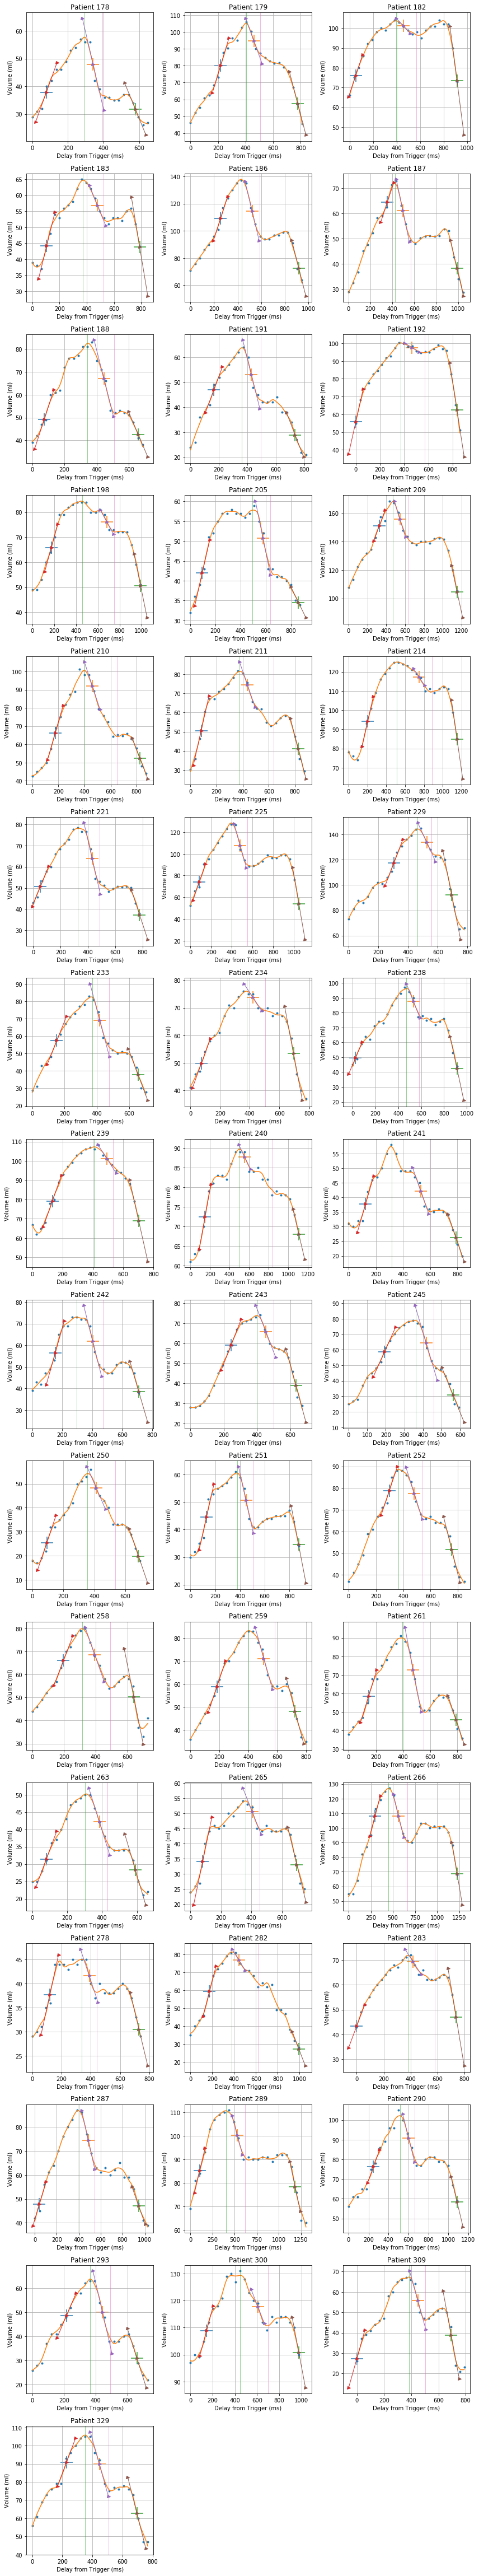

In [7]:
fig = plot_la_param(patients)
fig.savefig('la_results.png')

The final point is frequently identified as the maximum late emptying because of the behaviour of the filtering at the end of interval. We've tweaked the boundary mode in SG to try and minimise this - a combination of `interp` and `mirror` seems to be the most robust.

In [8]:
def plot_single_patient_la(patient, region='LA', lv_region='LV'):
    units, time_units = 'ml', 'ms'

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    patient_name = patient.pat_name
    volume_series = patient[region]
    times = np.asarray(volume_series.index)
    volumes = np.asarray(volume_series.values) 
    diffs = np.gradient(volumes) / np.diff(times)[0]
    r_to_r = times[-1]

    estimated_es_time = lv_es_time(
        np.asarray(patient[lv_region].values),
        np.asarray(patient[lv_region].index)
    )
        
    laparams = LAAnalysis(volumes, times, '%s %s' % (patient_name, region), estimated_es_time)

    ax[0].plot(times, volumes, '.')
    ax[0].plot(laparams.times, laparams.volumes, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)
    ax[0].set_title('Volume')
    ax[0].axvline(laparams.es_time, lw=0.5, color=next(ax[0]._get_lines.prop_cycler)['color'])
    ax[0].axvline(laparams.shoulder_time, lw=0.5, color=next(ax[0]._get_lines.prop_cycler)['color'])
    
    # maximum slopes
    plot_tangent((laparams.filling_time, laparams.filling_vol), slope=laparams.filling_slope, axes=ax[0])
    plot_tangent((laparams.early_emptying_time, laparams.early_emptying_vol), slope=laparams.early_emptying_slope, axes=ax[0])
    plot_tangent((laparams.late_emptying_time, laparams.late_emptying_vol), slope=laparams.late_emptying_slope, axes=ax[0])

    ax[1].plot(times, diffs, '.')
    ax[1].plot(laparams.times, laparams.derivatives, '-')
    ax[1].grid(True)
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Filling Rate (%s)' % 'ml/ms')    
    ax[1].set_title('Flow')    
    ax[1].axvline(laparams.es_time, lw=0.5, color=next(ax[1]._get_lines.prop_cycler)['color'])
    ax[1].axvline(laparams.shoulder_time, lw=0.5, color=next(ax[1]._get_lines.prop_cycler)['color'])

    ax[2].plot(times, np.gradient(diffs)/ np.diff(times)[0], '.')
    ax[2].plot(laparams.times, laparams.accels, '-')
    ax[2].grid(True)
    ax[2].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[2].set_ylabel('Filling Curvature (%s)' % 'ml/ms/ms')
    ax[2].set_title('Acceleration')    
    ax[2].axvline(laparams.es_time, lw=0.5, color=next(ax[2]._get_lines.prop_cycler)['color'])
    ax[2].axvline(laparams.shoulder_time, lw=0.5, color=next(ax[2]._get_lines.prop_cycler)['color'])
 
    fig.suptitle('%s' % patient_name, fontsize=14)

    fig.set_tight_layout(True)    


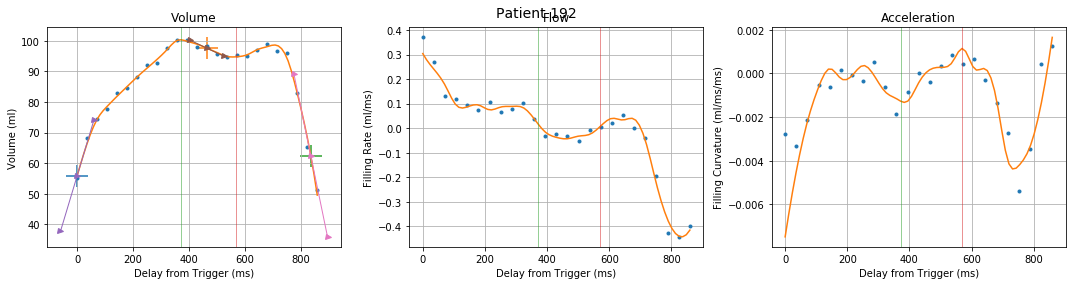

In [9]:
example_no = 192
plot_single_patient_la(patients[example_no])

### Save numerical results to spreadsheet

In [10]:
def la_results_dict(patients, region='LA', lv_region='LV'):
    results = OrderedDict()
    for key, patient in sorted(patients.items()):
        times = np.asarray(patient[region].index)
        volumes = np.asarray(patient[region].values)
        estimated_es_time = lv_es_time(
            np.asarray(patient[lv_region].values),
            np.asarray(patient[lv_region].index)
        )
        laparams = LAAnalysis(volumes, times, '%s %s' % (patient.pat_name, region), estimated_es_time)
        results[key] = laparams.summary()
    return results

df_results = pd.DataFrame.from_dict(la_results_dict(patients), orient='index')
df_results.insert(0, 'RR_ms', df_times['RR'])

df_results.to_excel('la_results.xlsx', sheet_name='LA', index_label='PatNo', float_format='%0.2f')

pd.set_option('precision', 0)
df_results.head(20).T

,178,179,182,183,186,187,188,191,192,198,205,209,210,211,214,221,225,229,233,234
RR_ms,674,845,952,822,984,1091,714,845,896,1034,909,1200,909,909,1200,811,1091,811,732,811
LA_time_end_systole,289,406,395,373,434,425,343,362,372,456,495,467,401,377,514,326,396,463,370,379
LA_peak_filling_ml_sec,179,270,178,173,268,132,217,153,304,159,140,180,249,303,216,157,278,306,231,148
LA_time_peak_filling,79,219,49,107,255,354,74,164,0,174,94,327,177,83,202,53,85,305,152,74
LA_vol_peak_filling,38,80,76,44,109,64,49,47,56,66,42,151,66,51,94,51,74,118,57,50
LA_early_peak_emptying_ml_sec,277,225,64,105,363,207,278,229,43,80,155,213,218,199,74,279,338,256,348,82
LA_time_early_peak_emptying,52,55,62,107,89,71,102,66,93,228,83,78,59,59,234,105,85,63,47,42
LA_vol_early_peak_emptying,48,95,101,57,114,61,67,53,98,76,51,156,92,75,117,64,107,134,69,74
LA_late_peak_emptying_ml_sec,157,314,459,258,342,185,166,148,443,213,65,307,187,264,343,196,554,590,247,286
LA_time_late_peak_emptying,289,373,519,416,485,566,315,373,465,537,366,685,425,448,638,452,651,231,285,316
